In [1]:
import metaknowledge as mk
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import community
import pandas as pd


import chart_studio.plotly as py
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")


import metaknowledge as mk
RC = mk.RecordCollection(r'D:\python科学计量可视化\数据\Demo data\Python-Wos', cached = True)
RC2021 = RC.yearSplit(2020,2021)
df = pd.DataFrame(RC2021.makeDict())
print(len(df))
df.head()

783


,PT,AU,AF,TI,SO,LA,DT,DE,ID,AB,...,PM,HC,HP,CT,CY,CL,num-Authors,num-Male,num-Female,num-Unknown
0,J,"[Shu, F, Quan, W, Chen, BK, Qiu, JP, Sugimoto,...","[Shu, Fei, Quan, Wei, Chen, Bikun, Qiu, Junpin...",The role of Web of Science publications in Chi...,SCIENTOMETRICS,English,Article,"[web of science, tenure assessment, china, uni...",[IMPACT FACTOR],Tenure provides a permanent position to facult...,...,None,None,None,None,None,None,6,1,1,4
1,J,"[Zhang, J, Chen, Y, Zhao, YH, Wolfram, D, Ma, FC]","[Zhang, Jin, Chen, Ye, Zhao, Yuehua, Wolfram, ...",Public health and social media: A study of Zik...,JOURNAL OF THE ASSOCIATION FOR INFORMATION SCI...,English,Article,None,[TWITTER],This study investigates the content of questio...,...,None,None,None,None,None,None,5,1,0,4
2,J,"[Liu, J, Grubler, A, Ma, TJ, Kogler, DF]","[Liu, Jie, Grubler, Arnulf, Ma, Tieju, Kogler,...",Identifying the technological knowledge deprec...,SCIENTOMETRICS,English,Article,"[knowledge depreciation, patent citation, sola...","[RESEARCH-AND-DEVELOPMENT, LIFE-CYCLES, EVOLUT...",Technological knowledge can be created via R&D...,...,None,None,None,None,None,None,4,1,0,3
3,J,"[Mohammed, S, Morgan, A, Nyantakyi, E]","[Mohammed, Shaibu, Morgan, Anthony, Nyantakyi,...",On the influence of uncited publications on a ...,SCIENTOMETRICS,English,Article,"[hirsch h-index, apparent h-index, citations, ...","[IMPACT, INDICATORS]",A researcher's output comprises cited and unci...,...,None,None,None,None,None,None,3,2,0,1
4,J,"[Fang, ZC, Dudek, J, Costas, R]","[Fang, Zhichao, Dudek, Jonathan, Costas, Rodrigo]",The Stability of Twitter Metrics: A Study on U...,JOURNAL OF THE ASSOCIATION FOR INFORMATION SCI...,English,Article,None,"[BROADER IMPACT, ALTMETRICS]",This study investigated the stability of Twitt...,...,None,None,None,None,None,None,3,2,0,1


In [2]:
cocite_net = RC2021.networkCoCitation(dropAnon=True,dropNonJournals=True,coreOnly=True)
print(mk.graphStats(cocite_net))

Nodes: 114
Edges: 80
Isolates: 49
Self loops: 1
Density: 0.0124204
Transitivity: 0.768293


### 先删除自循环点/边

In [3]:
mk.dropEdges(cocite_net,minWeight=1,dropSelfLoops=True)
print(mk.graphStats(cocite_net))

Nodes: 114
Edges: 79
Isolates: 49
Self loops: 0
Density: 0.0122652
Transitivity: 0.768293


### 再剔除孤立点数据

In [4]:
def filter_isolate_nodes(G, min_count=1):
    print('未剔除孤立点之前的网络数据集基础信息：\n')
    print(mk.graphStats(G)+'\n')
    G_filter = G.subgraph([j for c in nx.connected_components(G) if len(c) > min_count for j in c])
    return G_filter

未剔除孤立点之前的网络数据集基础信息：

Nodes: 114
Edges: 79
Isolates: 49
Self loops: 0
Density: 0.0122652
Transitivity: 0.768293

Graph with 65 nodes and 79 edges


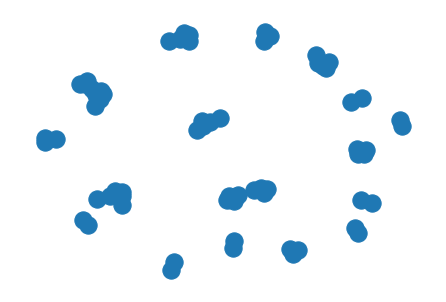

In [5]:
cocite_net_filter = filter_isolate_nodes(cocite_net)
print(cocite_net_filter)
nx.draw_spring(cocite_net_filter)

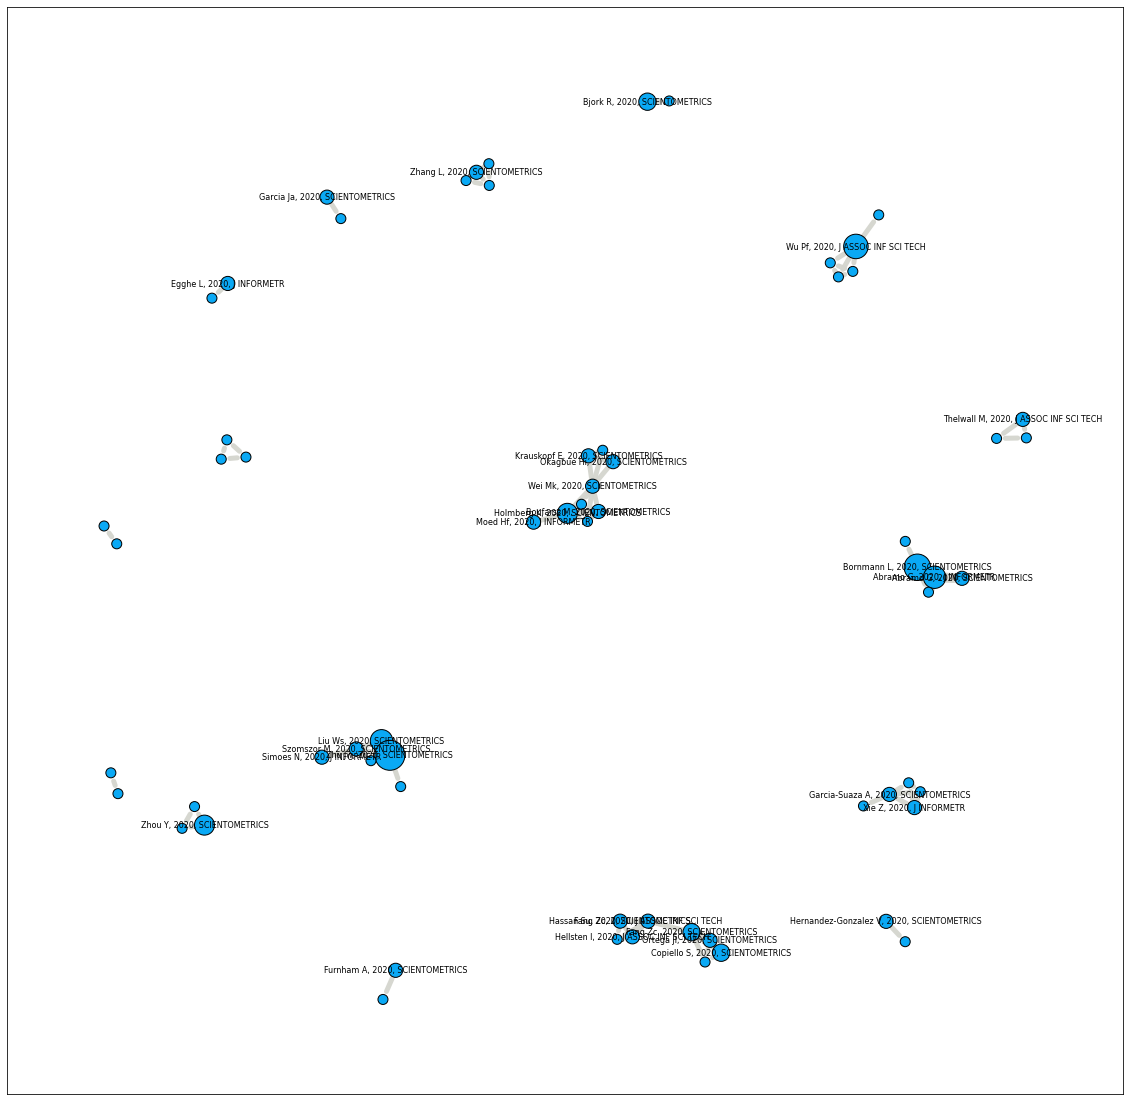

In [6]:
node_size = [v['count']*100 for k,v in cocite_net_filter.nodes.data()]
edge_width = [v[-1]['weight']*5 for v in cocite_net_filter.edges.data()]

plt.figure(figsize=(20,20))
pos = nx.spring_layout(cocite_net_filter,seed=42)

#按照连线的权重设置连线的粗细
edges = nx.draw_networkx_edges(cocite_net_filter,pos,edge_color='#D4D5CE',alpha=0.95,width=edge_width,arrows=True)

#按照节点count计数属性或者节点度相关指标进行节点大小设置
nodes = nx.draw_networkx_nodes(cocite_net_filter,pos,edgecolors='k',node_size=node_size,node_color='#0AA9F5')

# #按照节点count计数属性或者节点度相关指标进行标签大小设置
G_sub = cocite_net_filter.subgraph([k for k,v in cocite_net_filter.nodes.data() if v['count'] >1])
nx.draw_networkx_labels(G_sub,pos,font_size=8)

plt.savefig('figures/co-citation.png',dpi=300,bbox='tight')

未剔除孤立点之前的网络数据集基础信息：

Nodes: 114
Edges: 79
Isolates: 49
Self loops: 0
Density: 0.0122652
Transitivity: 0.768293

Graph with 42 nodes and 63 edges


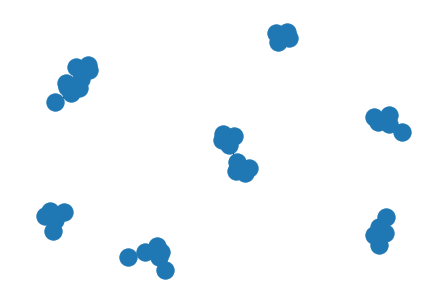

In [7]:
cocite_net_filter = filter_isolate_nodes(cocite_net,min_count=3)
print(cocite_net_filter)
nx.draw_spring(cocite_net_filter)

Modularity: 0.8415248897290486


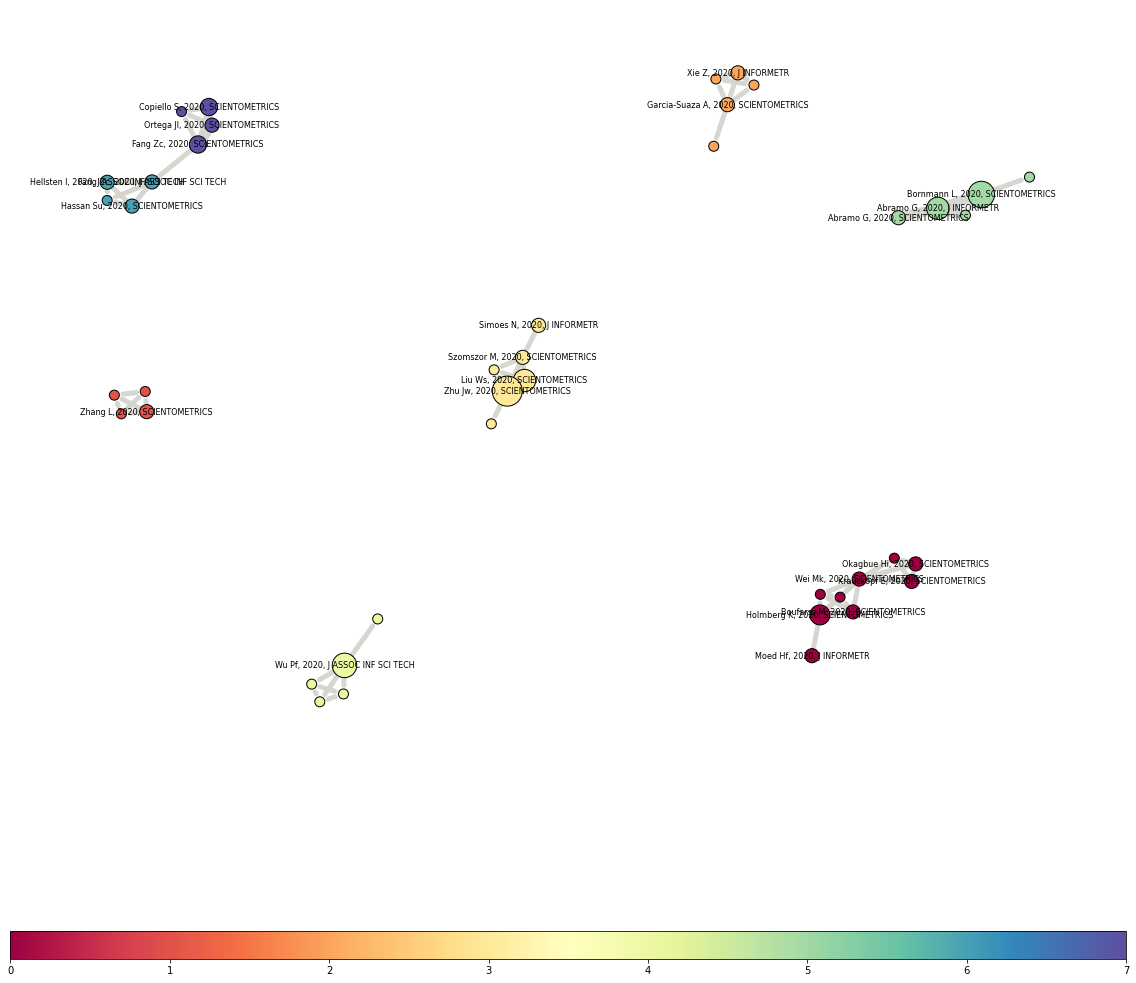

In [8]:
#根据网络社团进行着色
partion_ci = community.best_partition(cocite_net_filter)
modularity = community.modularity(partion_ci,cocite_net_filter)
print('Modularity:',modularity)

color_ci = [partion_ci[n] for n in cocite_net_filter.nodes()]
node_size = [v['count']*100 for k,v in cocite_net_filter.nodes.data()]
edge_width = [v[-1]['weight']*5 for v in cocite_net_filter.edges.data()]

fig = plt.figure(figsize=(20,20))
pos = nx.spring_layout(cocite_net_filter,seed=3)

#按照连线的权重设置连线的粗细
edges = nx.draw_networkx_edges(cocite_net_filter,pos,edge_color='#D4D5CE',alpha=0.95,width=edge_width,arrows=True)

#按照节点count计数属性或者节点度相关指标进行节点大小设置
nodes = nx.draw_networkx_nodes(cocite_net_filter,pos,edgecolors='k',node_size=node_size,node_color=color_ci,cmap=plt.cm.Spectral)

# #按照节点count计数属性或者节点度相关指标进行标签大小设置
G_sub = cocite_net_filter.subgraph([k for k,v in cocite_net_filter.nodes.data() if v['count'] >1])
nx.draw_networkx_labels(G_sub,pos,font_size=8)

#显示色谱条,只需要修改cmap色谱主题、location颜色条放置位置，aspect颜色条大小
import matplotlib as mpl
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Spectral)
pc.set_array(color_ci)
ax = plt.gca()
ax.set_axis_off()
cb = plt.colorbar(pc, ax=ax,location='bottom',aspect =40)

plt.savefig('figures/co-citation_nodes_up_2.png',dpi=300,bbox='tight')

In [9]:
def degreeStats(Graph):
    import pandas as pd
    
    deg = nx.degree_centrality(Graph)
    eig = nx.eigenvector_centrality(Graph,max_iter=500)
    bet = nx.betweenness_centrality(Graph)
    clo = nx.closeness_centrality(Graph)
    df = pd.DataFrame([deg, eig, bet, clo],index=['degree', 'eigenvector', 'betweenness', 'closeness']).T
    return df

df = degreeStats(cocite_net_filter)
df['count'] = [v['count'] for k,v in cocite_net_filter.nodes.data()]
df.sort_values('count',ascending=False)[:20]

,degree,eigenvector,betweenness,closeness,count
"Zhu Jw, 2020, SCIENTOMETRICS",0.097561,3.840115e-06,0.004878,0.101626,9
"Bornmann L, 2020, SCIENTOMETRICS",0.073171,9.364672e-11,0.003659,0.078049,7
"Wu Pf, 2020, J ASSOC INF SCI TECH",0.097561,1.569964e-06,0.003659,0.097561,6
"Abramo G, 2020, J INFORMETR",0.073171,9.364672e-11,0.003659,0.078049,5
"Liu Ws, 2020, SCIENTOMETRICS",0.073171,3.548683e-06,0.000000,0.087108,5
"Holmberg K, 2020, SCIENTOMETRICS",0.121951,4.006708e-01,0.008537,0.141907,4
"Fang Zc, 2020, SCIENTOMETRICS",0.097561,1.800924e-05,0.014634,0.119512,3
"Copiello S, 2020, SCIENTOMETRICS",0.073171,1.382375e-05,0.000000,0.085366,3
"Moed Hf, 2020, J INFORMETR",0.024390,9.197016e-02,0.000000,0.086721,2
"Okagbue Hi, 2020, SCIENTOMETRICS",0.073171,2.134753e-01,0.000000,0.111498,2
